# Design a recommender system on MovieLens Dataset

## Questions
1. Make a good analysis of the dataset.
2. Build regression models to predict movie revenue and vote
averages.
3. Use collaborative filtering to build a movie recommendation
system with two functions :
- 3.1 Suggest top N movies similar to a given movie title.
- 3.2 Predict user rating for the movies they have not rated for. You
may use a test set to test your prediction accuracy, 
in which the test ratings can be regarded as not rated during training.
Data can be found here https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset

# 1. Making a good analysis of the dataset

## 1.1. Running PySpark on Colab

In [ ]:
 # install Java
! apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
# install spark (change the version number if needed)
! wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

In [ ]:
# unzip the spark file to the current folder
! tar xf spark-3.0.0-bin-hadoop3.2.tgz

In [ ]:
# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

In [ ]:
# install findspark using pip
! pip install -q findspark

# ! pip install pyspark

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark

In [ ]:
# ! pip install pandas-datareader

In [ ]:
# # We have to restart the runtime after these two execution command
# ! pip install --upgrade pandas
# ! pip install --upgrade pandas-datareader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.2. Reading the data

- The movies_metadata.csv file is the main Movies Metadata file containing information on 45,000 movies featured in the Full MovieLens dataset. It includes information such as posters, backdrops, budget, revenue, release dates, languages, production countries and companies.

- The keywords.csv file contains the movie plot keywords for the movies in the MovieLens dataset, presented as a stringified JSON Object. 

- The credits.csv file includes cast and crew information for all the movies, also in the form of a JSON Object.

- The links.csv file contains the TMDB and IMDB IDs for all the movies in the Full MovieLens dataset.

- The ratings.csv file has 26 million ratings from 270,000 users for all 45,000 movies, with ratings on a scale of 1-5 obtained from the official GroupLens website.



In [ ]:
# Loading the dataframes - data can be found here : https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset

metadata_df = spark.read.format("com.databricks.spark.csv") \
    .options(multiline="True", header="True", inferSchema="True", delimiter=',', escape="\"") \
    .csv('/content/drive/MyDrive/Colab_files/csv_files/movies_metadata.csv')

keywords_df = spark.read.format("com.databricks.spark.csv") \
    .options(multiline="True", header="True", inferSchema="True", delimiter=',', escape="\"") \
    .csv('/content/drive/MyDrive/Colab_files/csv_files/keywords.csv')

credits_df = spark.read.format("com.databricks.spark.csv") \
    .options(multiline="True", header="True", inferSchema="True", delimiter=',', escape="\"") \
    .csv('/content/drive/MyDrive/Colab_files/csv_files/credits.csv')

links_df = spark.read.format("com.databricks.spark.csv") \
    .options(multiline="True", header="True", inferSchema="True", delimiter=',', escape="\"") \
    .csv('/content/drive/MyDrive/Colab_files/csv_files/links.csv')

ratings_df = spark.read.format("com.databricks.spark.csv") \
    .options(multiline="True", header="True", inferSchema="True", delimiter=',', escape="\"") \
    .csv('/content/drive/MyDrive/Colab_files/csv_files/ratings_small.csv')

## 1.3. Let's begin with some EDA (Exploratory Data Analysis)

In [ ]:
# Printing the schema of a dataframe

def print_schema(df) :
  return df.printSchema()

dataframes = [metadata_df, keywords_df, credits_df, links_df, ratings_df]
for df in dataframes :
  print(df.show(1))
  print(print_schema(df))
  
  print("+++++++++++\n")

+-----+---------------------+--------+--------------------+--------------------+---+---------+-----------------+--------------+--------------------+----------+--------------------+--------------------+--------------------+------------+---------+-------+--------------------+--------+-------+---------+-----+------------+----------+
|adult|belongs_to_collection|  budget|              genres|            homepage| id|  imdb_id|original_language|original_title|            overview|popularity|         poster_path|production_companies|production_countries|release_date|  revenue|runtime|    spoken_languages|  status|tagline|    title|video|vote_average|vote_count|
+-----+---------------------+--------+--------------------+--------------------+---+---------+-----------------+--------------+--------------------+----------+--------------------+--------------------+--------------------+------------+---------+-------+--------------------+--------+-------+---------+-----+------------+----------+
|Fal

In [ ]:
# Some descriptive stats of the dataframes

def descriptive_stats(df) :
  return df.summary().show() # describe()

dataframes_str = ['metadata', 'keywords', 'credits', 'links', 'ratings']

for dfstr, df in zip(dataframes_str, dataframes) :
  print(str(dfstr))
  print((df.count(), len(df.columns)))
  print(descriptive_stats(df))

metadata
(45572, 24)
+-------+-------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+-----------------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+------------------+------------------+--------------------+
|summary|              adult|belongs_to_collection|              budget|              genres|            homepage|                  id|             imdb_id| original_language|                     original_title|            overview|          popularity|         poster_path|production_companies|production_countries|        release_date|             revenue|             runtime|    spoken_languages|              status|             tagline|          title|   

In [ ]:
from pyspark.sql.functions import when, count, col, isnan

# Number of missing values for each dataframe and column

def nb_of_nans(df) :
  df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

for dfstr, df in zip(dataframes_str, dataframes) :
  print(str(dfstr))
  print(nb_of_nans(df))

metadata
+-----+---------------------+------+------+--------+---+-------+-----------------+--------------+--------+----------+-----------+--------------------+--------------------+------------+-------+-------+----------------+------+-------+-----+-----+------------+----------+
|adult|belongs_to_collection|budget|genres|homepage| id|imdb_id|original_language|original_title|overview|popularity|poster_path|production_companies|production_countries|release_date|revenue|runtime|spoken_languages|status|tagline|title|video|vote_average|vote_count|
+-----+---------------------+------+------+--------+---+-------+-----------------+--------------+--------+----------+-----------+--------------------+--------------------+------------+-------+-------+----------------+------+-------+-----+-----+------------+----------+
|    0|                40981|    17|    23|   37635| 31|    125|               45|            32|     985|       120|        481|                 124|                 120|         194|

In [ ]:
# Cleaning the ram

import gc
gc.collect()

235

## 1.4. Let's perform some data cleaning

In [ ]:
import pyspark

# Shape

def sparkShape(dataFrame) :
    return (dataFrame.count(), len(dataFrame.columns))
pyspark.sql.dataframe.DataFrame.shape = sparkShape

In [ ]:
# Handling nans

# Drop rows with null values in "production_companies", "production_countries" and "genres" - useful columns to recommand a movie to a user
print(metadata_df.shape())
metadata_df = metadata_df.na.drop(subset=["genres", "production_countries", "production_companies"])
print(metadata_df.shape())

(45466, 24)
(45463, 24)


In [ ]:
from pyspark.sql.functions import col, isnan, when, count

# Remove records that are identified as corrupted in a Kaggle discussion thread

metadata_df = metadata_df.where(~col('id').isin('215848', '82663', '162372'))
print(metadata_df.shape())

(45461, 24)


In [ ]:
# Change the type of the data

metadata_df = metadata_df.withColumn('budget', col('budget').cast('integer')) \
                         .withColumn('revenue', col('revenue').cast('integer')) \
                         .withColumn('popularity', col('popularity').cast('float'))

In [ ]:
# Drop duplicates

metadata_df = metadata_df.drop_duplicates(['imdb_id'])
print(metadata_df.shape())

(45413, 24)


## 1.5. Performing EDA (Exploratory Data Analysis)

In [ ]:
# ! pip install koalas

In [ ]:
import databricks.koalas
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# convert to koalas dataset
ratings_koala_df = ratings_df.to_koalas()

# plot ratings distribution
ratings_koala_df = ratings_koala_df.astype({'rating': float})
ratings_koala_df['rating'].hist() 


- > Most of the movies are rated between 3 and 5 stars.

In [ ]:
# convert to koalas ds
metadata_koala_df = metadata_df.to_koalas()

# plot budget distribution
metadata_koala_df = metadata_koala_df.astype({'budget': float})
metadata_koala_df['budget'].hist(bins=20) 

- > Many films have a limited budget.

## 1.6. Let's perform some data cleaning yet again : focus on metadata dataframe

In [ ]:
metadata_df.show(5, truncate=False)

+-----+---------------------+------+---------------------------------------------------------------+--------+------+---------+-----------------+--------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+--------------------------------+--------------------------------------------------------+----------------------------------------------------------+------------+-------+-------+-------------------------------------------------------------------------------------------------------------------------------------------

We can observe that some columns have been stored in a hashmap format, which can create difficulties for data analysis and modeling. It is necessary to address this issue.

Hashmap columns : 
* belongs_to_collection
* genres
* production_companies
* production_countries
* spoken_languages

In [ ]:
print(metadata_df.columns)
print(metadata_df.shape())

['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'vote_average', 'vote_count']
(45413, 24)


In [ ]:
from pyspark.sql.functions import col, lit, round, current_date, datediff, date_format, months_between, year

# Drop corrupted records mentioned in a Kaggle forum conversation
metadata_df = metadata_df.where(~col('id').isin('215848', '162372', '82663'))

cols = ["production_companies", "production_countries", "genres"]
metadata_df = metadata_df.na.drop(subset=cols)

# Change some data types
metadata_df = metadata_df.withColumn('budget', col('budget').cast('float')) \
                         .withColumn('popularity', col('popularity').cast('float')) \
                         .withColumn('revenue', col('revenue').cast('float'))

# Convert release_date column into a movie age one 
metadata_df = metadata_df.withColumn("movie_age", round(months_between(current_date(), col("release_date")) / 12, 0)) \
                         .withColumn("movie_age", col("movie_age").cast('int'))

metadata_df = metadata_df.withColumn("year", date_format(col("release_date"), "yyyy"))

print(metadata_df.shape())

(45461, 26)


In [ ]:
metadata_df.show(5, truncate=False)

+-----+---------------------+------+---------------------------------------------------------------+--------+------+---------+-----------------+--------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+--------------------------------+--------------------------------------------------------+----------------------------------------------------------+------------+-------+-------+-------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.sql.functions import explode, map_keys, from_json, regexp_replace, when, count, col, isnan
from pyspark.sql.types import StringType, MapType
from pyspark.sql import functions as F


def regex_replace(df, col) :
  df = df.withColumn(col, regexp_replace(col, "None", "'no_data'"))
  return df

metadata_df = metadata_df.withColumnRenamed("id","id_ori") \
                         .withColumnRenamed("poster_path","poster_path_ori")

# Necessary to get non-null data on columns associated with 'belongs_to_collection'
# cols = metadata_df.columns
# for i in cols :
#   df = metadata_df.withColumn(i, regexp_replace(i, "None", "'no data'"))
df = regex_replace(metadata_df, 'belongs_to_collection')

# Assign a schema to a column containing JSON objects
schema = MapType(StringType(), StringType(), True)
mask = from_json(col('belongs_to_collection').cast("string"), schema)
df = df.withColumn("belongs_to_collection_value", mask)

# Retrieve the unique keys within a JSON object
distinct_keys_df = df.select(explode(map_keys(col('belongs_to_collection_value')))) \
                     .distinct()

# Transform the collection of keys into a list
key_list = list(map(lambda row: row[0], distinct_keys_df.collect()))

# Extract values associated with specific keys and place them in a new column
key_cols = map(lambda f: df['belongs_to_collection_value'].getItem(f).alias(str(f)), key_list)

df_ = df.select(*metadata_df.columns, *key_cols)
# df.printSchema()

print(df_.shape())
df_.show(5, truncate=False)

(45461, 30)
+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------+------+-------------------------------------------------------------------------------------------------+------------------------------------+------+---------+-----------------+---------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+--------------------------------+-----------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------

From the 'belongs_to_collection' column, we create 4 new ones : 
- 'id' 
- 'name'
- 'poster_path'
- 'backdrop_path'

In [ ]:
import pandas as pd
from pyspark.sql.functions import regexp_replace

# Method to replace commas with semicolons to address issues related to separators

def replace_comma_with_semicolon_in_column(df, column_name) :
    df = df.withColumn(column_name, regexp_replace(column_name, ",", ";"))
    return df

df_ = replace_comma_with_semicolon_in_column(df_, "overview")

df_.select("overview").show(5, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|overview                                                                                                                                                                                                                                                                                                                                                                                                   |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:

# Some other cleanings

def some_cleanings(df) :
  cols = ["id", "poster_path", "backdrop_path"]
  df = df.drop(*cols)

  cols = ["belongs_to_collection", "tagline", "homepage", "poster_path_ori"] # a list or a tuple
  df = df.drop(*cols)

  df = df.drop_duplicates(['imdb_id'])

  cols = ["production_companies", "production_countries", "genres"]
  df = df.na.drop(subset=cols)

  df = df.na.drop("all")

  cols = df.columns
  df = df.na.fill(value='no_data', subset=[*cols]) # df_.na.fill(value='no_data', subset=cols)

  return df


df_ = some_cleanings(df_)
print(df_.shape())

(45413, 23)


In [ ]:
print(metadata_df.shape())
print(df.shape())
print(df_.shape())
# df_.columns

(45461, 26)
(45461, 27)
(45413, 23)


In [ ]:
from pyspark.sql.functions import when, count, col, isnan

# Number of missing values for each dataframe and column

def number_of_nans(df) :
  cols = ['video']
  df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns if c not in cols]).show()

number_of_nans(df_)

+-----+------+------+------+-------+-----------------+--------------+--------+----------+--------------------+--------------------+------------+-------+-------+----------------+------+-----+------------+----------+---------+----+----+
|adult|budget|genres|id_ori|imdb_id|original_language|original_title|overview|popularity|production_companies|production_countries|release_date|revenue|runtime|spoken_languages|status|title|vote_average|vote_count|movie_age|year|name|
+-----+------+------+------+-------+-----------------+--------------+--------+----------+--------------------+--------------------+------------+-------+-------+----------------+------+-----+------------+----------+---------+----+----+
|    0|     1|     0|     0|      0|                0|             0|       0|         1|                   0|                   0|           0|      1|    256|               0|     0|    0|           1|         1|       82|   0|   0|
+-----+------+------+------+-------+-----------------+------

In [ ]:
df_.show(5, truncate=False)

+-----+------+---------------------------------------------------------------+------+---------+-----------------+--------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+--------------------------------------------------------+----------------------------------------------------------+------------+-------+-------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+

In [ ]:
# df.columns
cols = ['genres', 'production_companies', 'production_countries', 'spoken_languages']
df_.select([col for col in cols]).show(5, truncate=False) # df_.select(*cols).show(truncate=False)

+---------------------------------------------------------------+--------------------------------------------------------+----------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|genres                                                         |production_companies                                    |production_countries                                      |spoken_languages                                                                                                                                                                                          |
+---------------------------------------------------------------+--------------------------------------------------------+----------------------------------------------------------+-------------------------------------------------

In [ ]:
from pyspark.sql.functions import get_json_object, from_json, explode, map_keys, udf, count, when, col, isnan, coalesce, lit
from pyspark.sql.functions import concat_ws, regexp_replace, regexp_extract,to_date, year, split, array, collect_list
from pyspark.sql.types import StructType, StructField, ArrayType, StringType, IntegerType, MapType
import pyspark.sql.functions as f

# The columns 'genres', 'production_companies', 'production_countries' and 'spoken_languages' contain values in the form of JSON arrays

# Step 1 - Establish the schema  of the JSON array type
schema = ArrayType(
    StructType([
        StructField('id', IntegerType(), nullable=True), 
        StructField('name', StringType(), nullable=True)
    ])
)
schema_bis = ArrayType(
    StructType([
        StructField('iso_3166_1', StringType(), nullable=True), 
        StructField('name', StringType(), nullable=True)
    ])
)
schema_ter = ArrayType(
    StructType([
        StructField('iso_639_1', StringType(), nullable=True), 
        StructField('name', StringType(), nullable=True)
    ])
)

# Step 2 - Create a UDF function to convert a list of values into a string of semicolon-separated values, 
# as the data is in the format of a JSON array and extracting values based on JSON keys will result in a list.
udf_join = udf(lambda s: '; '.join(map(str, s)), StringType())

# Step 3 - Extracting and converting data from the JSON format
mask1 = from_json(df_.genres, schema).getField("name")
mask2 = from_json(df_.production_companies, schema).getField("name")
mask3 = from_json(df_.production_countries, schema_bis).getField("name")
mask4 = from_json(df_.spoken_languages, schema_ter).getField("name")

df__ = df_.filter(f.col('genres').startswith("[{")) \
          .filter(f.col('production_companies').startswith("[{")) \
          .filter(f.col('production_countries').startswith("[{")) \
          .filter(f.col('spoken_languages').startswith("[{")) \
          .withColumn("genres_value", when(col("genres")=='[]', '').otherwise(udf_join(mask1))) \
          .withColumn("production_companies_value", when(col("production_companies")=='[]', '').otherwise(udf_join(mask2))) \
          .withColumn("production_countries_value", when(col("production_countries")=='[]', '').otherwise(udf_join(mask3))) \
          .withColumn("spoken_languages_value", when(col("spoken_languages")=='[]', '').otherwise(udf_join(mask4))) \

print(df__.shape())
df__.show(5, truncate=False)

(32059, 27)
+-----+------+----------------------------------------------------------------------------------------------+------+---------+-----------------+---------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+--------------------------------------------------------+----------------------------------------------------------+------------+-------+-------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Removal of unnecessary columns

cols = ['genres', 'production_companies', 'production_countries', 'spoken_languages']
df__ = df__.drop(*cols)

print(df__.shape())
df__.show(5, truncate=False)

(32059, 23)
+-----+------+------+---------+-----------------+---------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+------------+-------+-------+--------+---------------------+-----+------------+----------+---------+----+-------+-----------------------+-----------------------------+--------------------------+---------------------------------------------+
|adult|budget|id_ori|imdb_id  |original_language|original_title       |overview                                                                                 

Resolve issues with special characters in certain columns, including Chinese, Spanish, and Arabic characters.

In [ ]:
cols = ['production_companies_value', 'spoken_languages_value'] # problem with special characters into these two columns
df__ = df__.drop(*cols)

df__ = replace_comma_with_semicolon_in_column(df__, 'genres_value')
df__ = replace_comma_with_semicolon_in_column(df__, 'production_countries_value')

print(df__.shape())
df__.show(5, truncate=False, vertical=False)

(32059, 21)
+-----+------+------+---------+-----------------+---------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+------------+-------+-------+--------+---------------------+-----+------------+----------+---------+----+-------+-----------------------+--------------------------+
|adult|budget|id_ori|imdb_id  |original_language|original_title       |overview                                                                                                                                                             

In [ ]:
df__.select("overview").show(5, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|overview                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [ ]:
# Write the cleaned metadata file to the local storage using the coalesce(1) method to store it in a single partition

# df__.coalesce(1).write \
#     .options(header='True', delimiter=',') \
#     .format("csv").save('/content/drive/MyDrive/Colab_files/csv_files/cleaned_movies_metadata_df.csv', mode='append')

df__.toPandas().to_csv("/content/drive/MyDrive/Colab_files/csv_files/cleaned_movies_metadata_df.csv", index=False, sep=",")

In [ ]:
# Read CSV file into a DataFrame

cleaned_movies_metadata_df = spark.read.options(multiline="True", header="True", inferSchema="True", delimiter=',', escape="\"") \
                                       .csv("/content/drive/MyDrive/Colab_files/csv_files/cleaned_movies_metadata_df.csv")

In [ ]:
print(cleaned_movies_metadata_df.shape())
cleaned_movies_metadata_df.show(5, truncate=False)

(32059, 21)
+-----+------+------+---------+-----------------+---------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+------------+-------+-------+--------+---------------------+-----+------------+----------+---------+----+-------+-----------------------+--------------------------+
|adult|budget|id_ori|imdb_id  |original_language|original_title       |overview                                                                                                                                                             

In [ ]:
cleaned_movies_metadata_df.select('id_ori', "genres_value", "production_countries_value").show(5, False)

+------+-----------------------+--------------------------+
|id_ori|genres_value           |production_countries_value|
+------+-----------------------+--------------------------+
|51359 |Comedy; Horror         |United States of America  |
|42565 |Drama; Crime           |United States of America  |
|42641 |Drama; Romance         |United States of America  |
|50072 |Drama                  |United States of America  |
|37215 |Romance; Drama; Fantasy|United States of America  |
+------+-----------------------+--------------------------+
only showing top 5 rows



## 1.7. Let's perform some data cleaning yet again : focus on credits dataframe

In [ ]:
credits_df = spark.read.format("com.databricks.spark.csv") \
    .options(multiline="True", header="True", inferSchema="True", delimiter=',', escape="\"") \
    .csv('/content/drive/MyDrive/Colab_files/csv_files/credits.csv')


credits_df.select("cast", "crew").show(5, truncate=False)
print(credits_df.shape())
credits_df.columns

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

['cast', 'crew', 'id']

In [ ]:
from pyspark.sql.functions import col, regexp_replace, regexp_extract, udf, from_json
from pyspark.sql.types import StructType, StructField, ArrayType, MapType, StringType, IntegerType

# The 'cast' column contains values in the form of a JSON string array. 
# The schema definition does not recognize the key if it is set to None.

def replace_cast(val) :
    val = val.replace("'profile_path': None", "'profile_path': no_data")
    return val

replaceUDF = udf(lambda x: replace_cast(x))

def regex_replace(df, col) :
  df = df.withColumn(col, regexp_replace(col, "None", "'no_data'"))
  return df


credits_df_ = credits_df.withColumn("cast", replaceUDF(col("cast")))
credits_df_ = regex_replace(credits_df, 'cast')

schema = ArrayType(
    StructType([
      StructField('cast_id', IntegerType(), nullable=True),
      StructField('character', StringType(), nullable=True),
      StructField('credit_id', StringType(), nullable=True),
      StructField('gender', IntegerType(), nullable=True),
      StructField('id', IntegerType(), nullable=True),
      StructField('name', StringType(), nullable=True),
      StructField('order', IntegerType(), nullable=True),
      StructField('profile_path', StringType(), nullable=True)
    ])
)

mask1 = from_json(credits_df.cast, schema).getField("name").alias('actors')
mask2 = regexp_extract(col('crew'), "(.)('job': 'Director', 'name': ')((\w+)(\s+)(\w+))", 3)

credits_df_ = credits_df.withColumn('actors', mask1) \
                        .withColumn('director', mask2)

credits_df_.select("id", "actors", "director").show(5, truncate=False)

+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+
|id   |actors                                                                                                                                                                                       |director       |
+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+
|862  |null                                                                                                                                                                                         |John Lasseter  |
|8844 |null                                                                                                                                     

In [ ]:
# New actors columns

credits_df__ = credits_df_.select("id", "actors", "director")
split_col = col('actors')
credits_df__ = credits_df__.withColumn('actor_1', split_col.getItem(0)) \
                           .withColumn('actor_2', split_col.getItem(1)) \
                           .withColumn('actor_3', split_col.getItem(2)) 
  
credits_df__ = credits_df__.select(["id", "director", 'actor_1', 'actor_2', 'actor_3'])

print(credits_df__.shape())
credits_df__.show(5, truncate=False)

(45476, 5)
+-----+---------------+---------------+--------------+--------------+
|id   |director       |actor_1        |actor_2       |actor_3       |
+-----+---------------+---------------+--------------+--------------+
|862  |John Lasseter  |null           |null          |null          |
|8844 |Joe Johnston   |null           |null          |null          |
|15602|Howard Deutch  |Walter Matthau |Jack Lemmon   |Ann-Margret   |
|31357|Forest Whitaker|Whitney Houston|Angela Bassett|Loretta Devine|
|11862|Charles Shyer  |Steve Martin   |Diane Keaton  |Martin Short  |
+-----+---------------+---------------+--------------+--------------+
only showing top 5 rows



In [ ]:
# Write the cleaned credits dataframe to the local storage

credits_df__.toPandas().to_csv("/content/drive/MyDrive/Colab_files/csv_files/cleaned_credits_df.csv", index=False, sep=",")

In [ ]:
# Read CSV file into a DataFrame

cleaned_credits_df = spark.read.options(multiline="True", header="True", inferSchema="True", delimiter=',', escape="\"") \
                               .csv("/content/drive/MyDrive/Colab_files/csv_files/cleaned_credits_df.csv")


print(cleaned_credits_df.shape())
cleaned_credits_df.show(5, truncate=False)

(45476, 5)
+-----+---------------+---------------+--------------+--------------+
|id   |director       |actor_1        |actor_2       |actor_3       |
+-----+---------------+---------------+--------------+--------------+
|862  |John Lasseter  |null           |null          |null          |
|8844 |Joe Johnston   |null           |null          |null          |
|15602|Howard Deutch  |Walter Matthau |Jack Lemmon   |Ann-Margret   |
|31357|Forest Whitaker|Whitney Houston|Angela Bassett|Loretta Devine|
|11862|Charles Shyer  |Steve Martin   |Diane Keaton  |Martin Short  |
+-----+---------------+---------------+--------------+--------------+
only showing top 5 rows



## 1.8. Joining the useful dataframes

In [ ]:
ratings_df = spark.read.format("com.databricks.spark.csv") \
    .options(multiline="True", header="True", inferSchema="True", delimiter=',', escape="\"") \
    .csv('/content/drive/MyDrive/Colab_files/csv_files/ratings_small.csv')


ratings_df.show(5, truncate=False)

+------+-------+------+----------+
|userId|movieId|rating|timestamp |
+------+-------+------+----------+
|1     |31     |2.5   |1260759144|
|1     |1029   |3.0   |1260759179|
|1     |1061   |3.0   |1260759182|
|1     |1129   |2.0   |1260759185|
|1     |1172   |4.0   |1260759205|
+------+-------+------+----------+
only showing top 5 rows



In [ ]:
# Joining 'cleaned_movies_metadata_df', 'cleaned_credits_df' & 'ratings_df' into a single dataframe

cleaned_credits_df = cleaned_credits_df.withColumn("id", col("id").cast(StringType()))
cleaned_movies_metadata_df = cleaned_movies_metadata_df.withColumn("id_ori", col("id_ori").cast(StringType()))

joined_df = cleaned_movies_metadata_df.join(cleaned_credits_df, cleaned_movies_metadata_df.id_ori==cleaned_credits_df.id, how='inner') \
                                      .join(ratings_df, cleaned_movies_metadata_df.id_ori==ratings_df.movieId, how='inner')


print(joined_df.shape())
joined_df.show(5, truncate=False)

(42497, 30)
+-----+---------+------+---------+-----------------+------------------+------------------------------------------------------------------------------------------------------------------------------+----------+------------+-------+-------+--------+------------------+-----+------------+----------+---------+----+-------+------------+--------------------------+---+---------------+-------+-------+-------+------+-------+------+----------+
|adult|budget   |id_ori|imdb_id  |original_language|original_title    |overview                                                                                                                      |popularity|release_date|revenue|runtime|status  |title             |video|vote_average|vote_count|movie_age|year|name   |genres_value|production_countries_value|id |director       |actor_1|actor_2|actor_3|userId|movieId|rating|timestamp |
+-----+---------+------+---------+-----------------+------------------+-------------------------------------------

In [ ]:
joined_df.toPandas().to_csv("/content/drive/MyDrive/Colab_files/csv_files/joined_df.csv", index=False, sep=",")

In [ ]:
# Read CSV file into DataFrame

joined_df = spark.read.options(multiline="True", header="True", inferSchema="True", delimiter=',', escape="\"") \
                      .csv("/content/drive/MyDrive/Colab_files/csv_files/joined_df.csv")

print(joined_df.shape())
joined_df.show(5, truncate=False)

(42497, 30)
+-----+---------+------+---------+-----------------+------------------+------------------------------------------------------------------------------------------------------------------------------+----------+------------+-------+-------+--------+------------------+-----+------------+----------+---------+----+-------+------------+--------------------------+---+---------------+-------+-------+-------+------+-------+------+----------+
|adult|budget   |id_ori|imdb_id  |original_language|original_title    |overview                                                                                                                      |popularity|release_date|revenue|runtime|status  |title             |video|vote_average|vote_count|movie_age|year|name   |genres_value|production_countries_value|id |director       |actor_1|actor_2|actor_3|userId|movieId|rating|timestamp |
+-----+---------+------+---------+-----------------+------------------+-------------------------------------------

## 1.9 Summary of numerical values

In [ ]:
# Read CSV file into a DataFrame

cleaned_movies_metadata_df = spark.read.options(multiline="True", header="True", inferSchema="True", delimiter=',', escape="\"") \
                                       .csv("/content/drive/MyDrive/Colab_files/csv_files/cleaned_movies_metadata_df.csv")

cols = ('runtime', 'budget', 'vote_count', 'popularity', 'revenue', 'vote_average')
cleaned_movies_metadata_df.select(*cols) \
                          .summary("count", "min", "25%", "75%", "max").show()

+-------+-------+------+----------+----------+-----------+------------+
|summary|runtime|budget|vote_count|popularity|    revenue|vote_average|
+-------+-------+------+----------+----------+-----------+------------+
|  count|  31997| 32059|     32059|     32059|      32059|       32059|
|    min|    0.0|   0.0|         0|       0.0|        0.0|         0.0|
|    25%|   88.0|   0.0|         5|   0.65691|        0.0|         5.3|
|    75%|  109.0|   6.0|        59|  5.508101|        0.0|         6.8|
|    max|  931.0| 3.8E8|     14075|  547.4883|2.7879652E9|        10.0|
+-------+-------+------+----------+----------+-----------+------------+



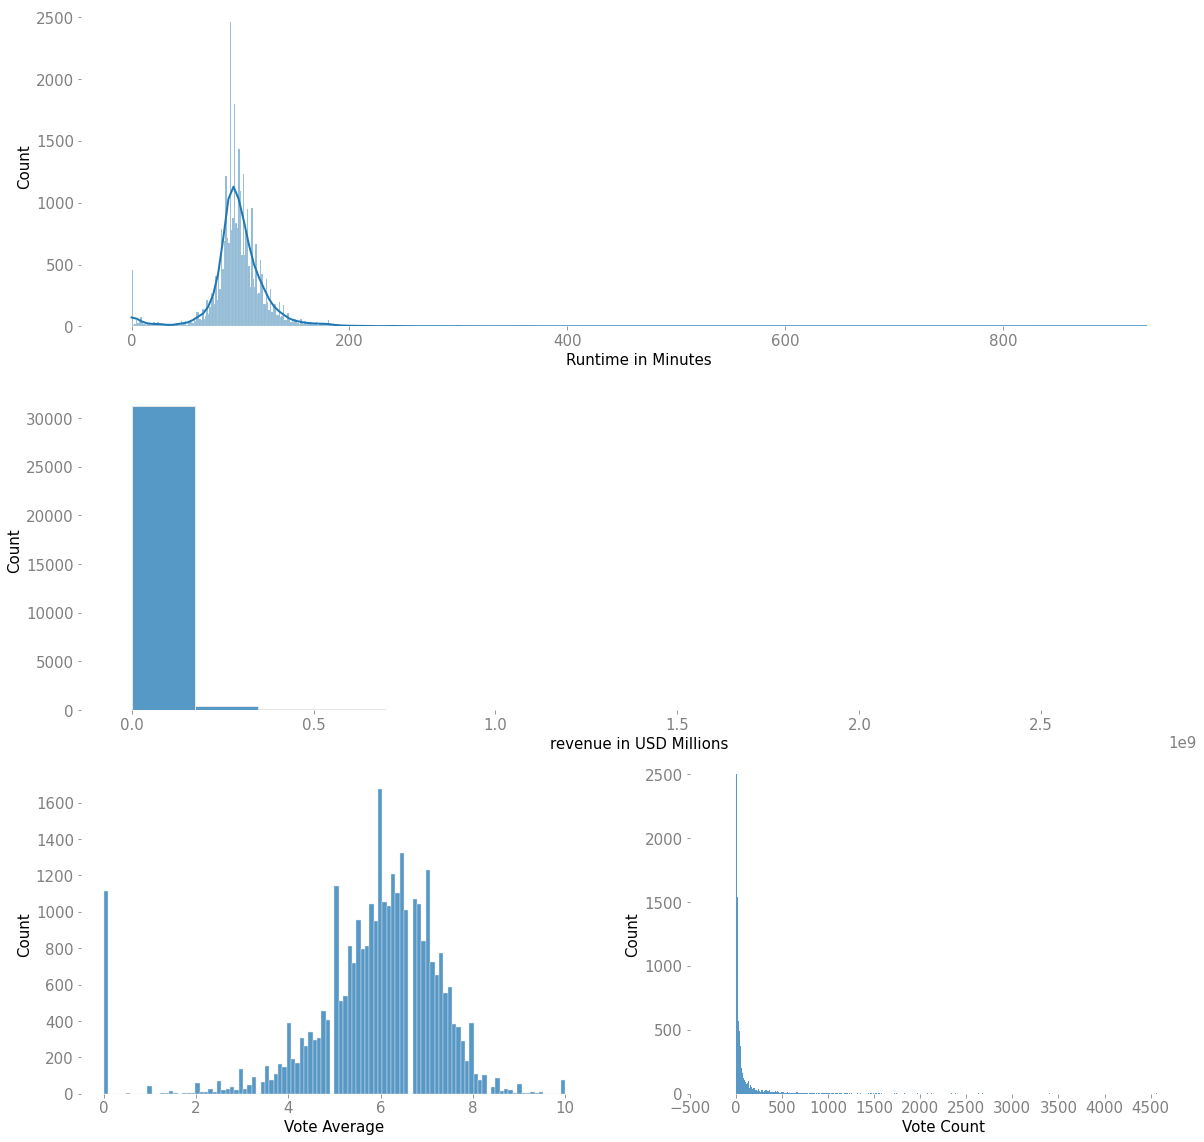

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cycler

pandasDF = cleaned_movies_metadata_df.select("runtime", "vote_count", "revenue","vote_average") \
                                     .toPandas()

colors = cycler('color', ['#EE6666', '#3388BB', '#9988DD', '#EECC55', '#88BB44', '#FFBBBB'])

plt.rc('axes', facecolor='#ffffff', edgecolor='none', axisbelow=True, grid=True)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)
plt.rc(('xtick', 'ytick'), labelsize=15)
plt.rcParams['axes.labelsize'] = 15


fig = plt.figure(figsize=(20,20))
grid = plt.GridSpec(3, 2, wspace=0.2, hspace=0.2)


f1=sns.histplot(data=pandasDF, x="runtime", kde=True, ax=fig.add_subplot(grid[0, :]))
f1.set_xlabel('Runtime in Minutes')

f2=sns.histplot(data=pandasDF, x="revenue", kde=False, ax=fig.add_subplot(grid[1,:]))
f2.set_xlabel('revenue in USD Millions')

f3=sns.histplot(data=pandasDF, x="vote_average", kde=False, ax=fig.add_subplot(grid[2, :1]))
f3.set_xlabel('Vote Average')

f3=sns.histplot(data=pandasDF, x="vote_count", kde=False, ax=fig.add_subplot(grid[2, 1]))
f3.set_xlabel('Vote Count')
f3.set_xlim(0, 5000)
f3.xaxis.set_ticks(np.arange(-500, 5000, 500))
f3.set_ylim(0, 2500)

plt.show()

## 1.10 Correlation of profit/loss with other attributes


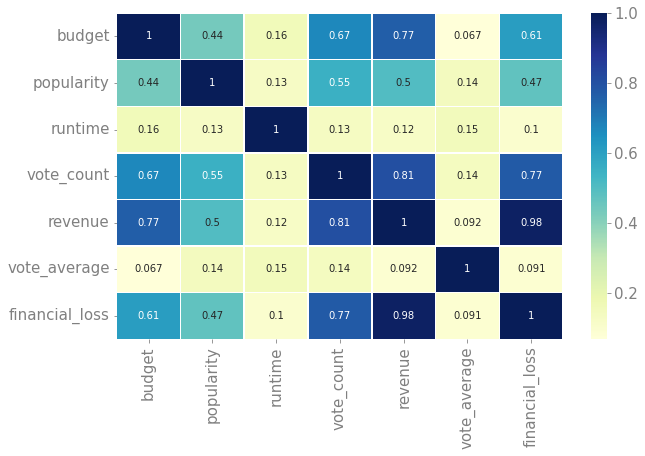

In [ ]:
from pyspark.sql.functions import col, lit, coalesce

mask = coalesce(col('revenue'), lit(0)) - coalesce(col('budget'), lit(0))
cols = ('budget', 'popularity', 'runtime', 'vote_count', 'year', 'revenue', 'vote_average')
correlation_df = cleaned_movies_metadata_df.select(*cols) \
                                           .withColumn("financial_loss", mask)

# Convert to a Pandas dataframe and remove rows with missing values
pandas_correlation_df = correlation_df.toPandas().dropna(how='any')

correlations = pandas_correlation_df.corr()

f, ax = plt.subplots(figsize=(10,6))
sns.heatmap(correlations, annot=True, cmap="YlGnBu", linewidths=.5)

plt.show()

## 1.11 Top N voted movies

In [ ]:
cleaned_movies_metadata_df.select('original_title', 'vote_count', 'vote_average').orderBy(col("vote_average").desc()).show(10, truncate=False)
cleaned_movies_metadata_df.select('original_title', 'vote_count', 'vote_average').show(10, truncate=False)

+---------------------------+----------+------------+
|original_title             |vote_count|vote_average|
+---------------------------+----------+------------+
|Let No Man Write My Epitaph|1         |10.0        |
|Ateş Böceği                |1         |10.0        |
|Sirokkó                    |1         |10.0        |
|Veliki transport           |2         |10.0        |
|Terug naar morgen          |1         |10.0        |
|Criminal Justice           |1         |10.0        |
|Stuey                      |1         |10.0        |
|李三腳威震地獄門           |1         |10.0        |
|Mammal                     |1         |10.0        |
|Kaze no naka no kodomo     |1         |10.0        |
+---------------------------+----------+------------+
only showing top 10 rows

+----------------------------+----------+------------+
|original_title              |vote_count|vote_average|
+----------------------------+----------+------------+
|The Haunted House           |16        |6.5         |
|Under

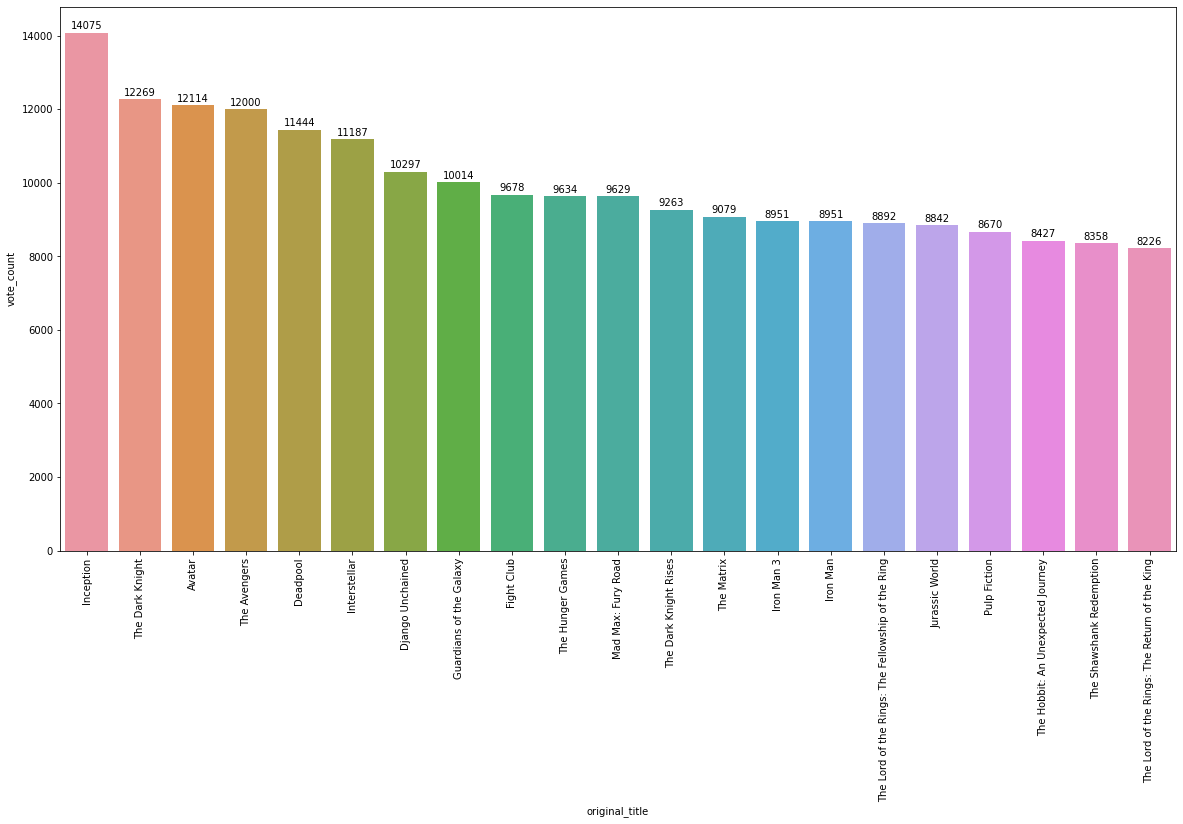

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


pandasDFvotecount = cleaned_movies_metadata_df.select('original_title','vote_count','vote_average').toPandas()
pandasDFvotecount = pandasDFvotecount.sort_values(by='vote_count',ascending=False).iloc[0:21,:].reset_index(drop=True)

mask = pandasDFvotecount['vote_count'] == 'False'
mask2 = pandasDFvotecount['vote_count'] == 'Broadway Serenade'
pandasDFvotecount.drop(pandasDFvotecount.loc[mask].index, inplace=True)
pandasDFvotecount.drop(pandasDFvotecount.loc[mask2].index, inplace=True)
pandasDFvotecount['vote_count'] = pandasDFvotecount['vote_count'].values.astype(float)


fig = plt.figure(figsize=(20,10))
ax = plt.subplot(111)
bar_plot = sns.barplot(x=pandasDFvotecount['original_title'], y=pandasDFvotecount['vote_count'], ax=ax)

for tick in bar_plot.get_xticklabels() :
    tick.set_rotation(90)


def single_plot(ax) :        
        for p in bar_plot.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()+100
            value = format(int(p.get_height()))
            ax.text(_x, _y, value, ha="center") 


single_plot(bar_plot)
plt.show()

## 1.12 Top N profitable movies at the box office

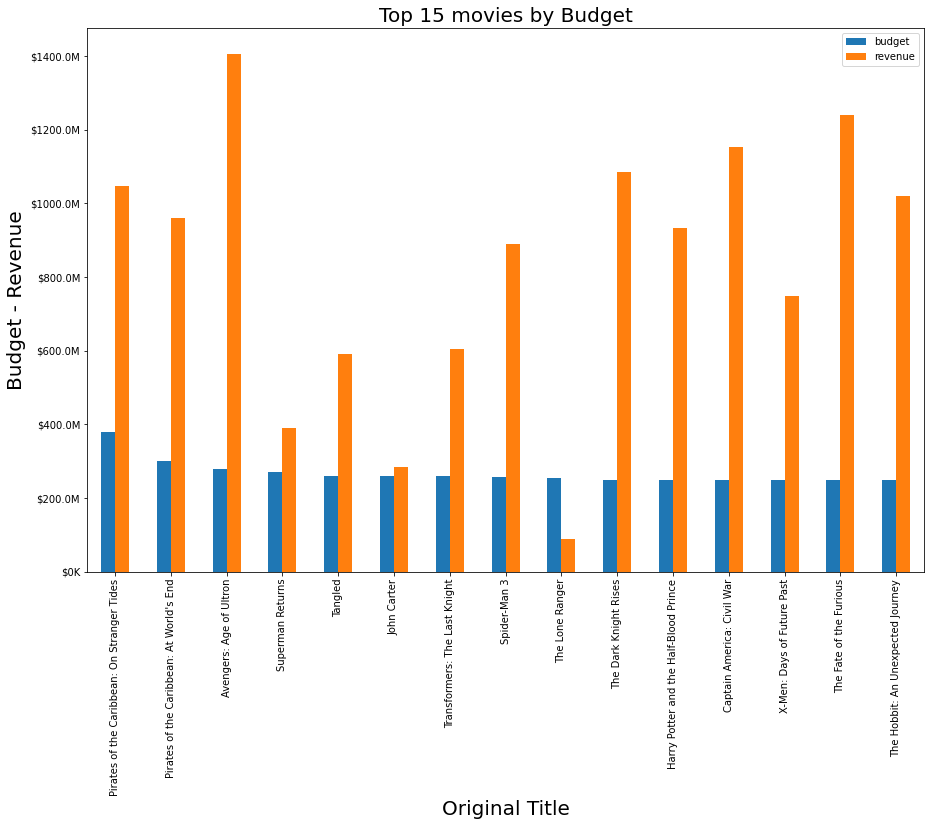

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import FuncFormatter


movies_by_budgetDF = cleaned_movies_metadata_df.select('id_ori', 'original_title', 'budget', 'revenue') \
                                               .orderBy(col('budget'), ascending=False)

# Convert into a Pandas dataframe
pandasDF_top15_movies_by_budget = movies_by_budgetDF.toPandas().head(15)
pandasDF_top15_movies_by_budget['budget'] = pandasDF_top15_movies_by_budget['budget'].values.astype(float)
pandasDF_top15_movies_by_budget['revenue'] = pandasDF_top15_movies_by_budget['revenue'].values.astype(float)


def money(x, pos) :
    "The two arguments are the value and tick position"
    if x >= 1000000 :
        return '${:1.1f}M'.format(x*1e-6)
    return '${:1.0f}K'.format(x*1e-3)


ax = pandasDF_top15_movies_by_budget.plot(x="original_title", y=["budget", "revenue"], kind="bar", figsize=(15, 10))
formatter = FuncFormatter(money)
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel('Original Title', fontsize=20)
ax.set_ylabel('Budget - Revenue', fontsize=20)
ax.set_title('Top 15 movies by Budget', fontsize=20, loc='center')
plt.show()

In [ ]:
# pandasDF_top15_movies_by_budget.dtypes

id_ori             object
original_title     object
budget            float64
revenue           float64
dtype: object

## 1.13 Top N movies that were considered financial failures

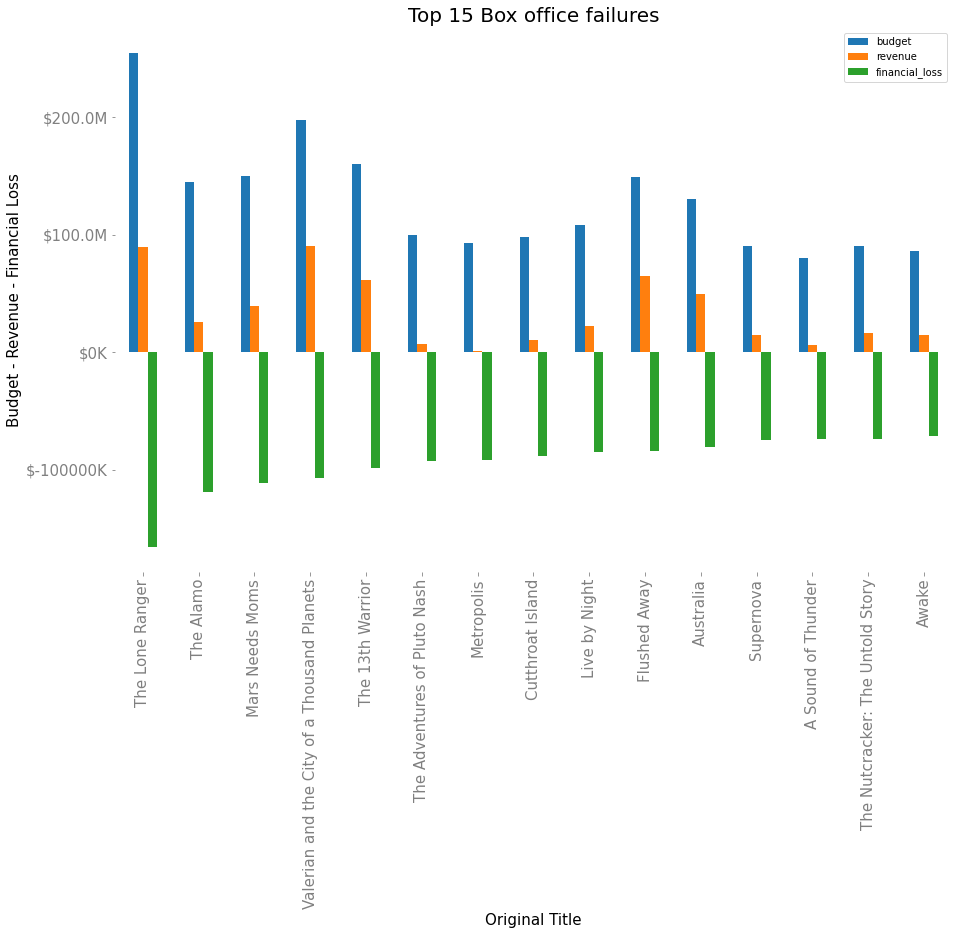

In [ ]:
from pyspark.sql.functions import col, lit, coalesce

mask = coalesce(col('revenue'), lit(0)) - coalesce(col('budget'), lit(0))
financial_lossDF = cleaned_movies_metadata_df \
                  .filter(col('revenue') > 0 ) \
                  .withColumn('financial_loss', mask) \
                  .filter(col('financial_loss') < 0) \
                  .select('id_ori','original_title', 'budget','revenue', 'financial_loss') \
                  .orderBy(col('financial_loss'),ascending=True)

financial_loss_pandasDF = financial_lossDF.toPandas().head(15)

ax = financial_loss_pandasDF.plot(x='original_title', y=['budget', 'revenue', 'financial_loss'], kind='bar', figsize=(15, 10))
formatter = FuncFormatter(money)
ax.yaxis.set_major_formatter(formatter)

ax.set_title('Top 15 Box office failures', fontsize=20, loc='center')
ax.set_xlabel('Original Title', fontsize=15)
ax.set_ylabel('Budget - Revenue - Financial Loss', fontsize=15)
plt.legend()
plt.show()